In [1]:
from __future__ import annotations

import abc
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from tqdm.autonotebook import tqdm

# Diffusion Models On MNIST

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## Data Loading

In [3]:
mnist_train_ds = torchvision.datasets.MNIST(
    'mnist',
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Lambda(lambda X: 2*X - 1),
    ]))

mnist_test_ds = torchvision.datasets.MNIST(
    'mnist',
    train=False,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Lambda(lambda X: 2*X - 1),
    ]))

## Diffusion Models
### Forward Process

In [4]:
class BetaScheduler(abc.ABC):
    def __init__(self, beta_start: float, beta_end: float, time_steps: int) -> None:
        self._time_steps = time_steps
        self._beta = self._schedule_beta(beta_start, beta_end, time_steps)
        self._alpha = 1. - self._beta
        self._alpha_bar = torch.cumprod(self._alpha, dim=0)
        self._1_minus_alpha_bar = 1. - self._alpha_bar
        self._sqrt_alpha_bar = torch.sqrt(self._alpha_bar)
        self._sqrt_1_minus_alpha_bar = torch.sqrt(self._1_minus_alpha_bar)

    @property
    def max_time_steps(self):
        return self._time_steps

    def beta(self, time_steps: torch.Tensor):
        return self._get_values_at(self._beta, time_steps)

    def alpha(self, time_steps: torch.Tensor):
        return self._get_values_at(self._alpha, time_steps)

    def one_minus_alpha_bar(self, time_steps: torch.Tensor):
        return self._get_values_at(self._1_minus_alpha_bar, time_steps)

    def sqrt_alpha_bar(self, time_steps: torch.Tensor):
        return self._get_values_at(self._sqrt_alpha_bar, time_steps)

    def sqrt_1_minus_alpha_bar(self, time_steps: torch.Tensor):
        return self._get_values_at(self._sqrt_1_minus_alpha_bar, time_steps)

    @abc.abstractmethod
    def _schedule_beta(self, beta_start: float, beta_end: float, time_steps: int) -> torch.Tensor:
        pass

    def _get_values_at(self, values: torch.Tensor, time_steps: torch.Tensor) -> torch.Tensor:
        """
        Obtain values at given time steps.

        Parameters
        ==========
        values: torch.Tensor
            A tensor of shape (T,) containing values to be extracted at each time step.
        time_steps: torch.Tensor
            Time steps to be extracted, can be a tensor of shape (N, ) or a scalar tensor.
        """
        if len(time_steps.shape) == 0:
            return values[time_steps]

        v = torch.gather(values, 0, time_steps)
        return v[:, None]


class LinearBetaScheduler(BetaScheduler):
    def _schedule_beta(self, beta_start: float, beta_end: float, time_steps: int) -> torch.Tensor:
        return torch.linspace(beta_start, beta_end, time_steps)


class DiffusionForwardProcess:
    def __init__(self, beta_scheduler: BetaScheduler) -> None:
        self._beta_scheduler = beta_scheduler

    @property
    def max_time_steps(self):
        return self._beta_scheduler.max_time_steps

    @torch.no_grad()
    def forward(self, img: torch.Tensor, time_steps: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Perform diffusion forward process based on the nice property:
        q(x_t | x_0) = Normal(x_t; \sqrt{\bar{\alpha_t}}x_0, (1 - \bar{\alpha_t})I

        Parameters
        ==========
        img: torch.Tensor
            The original image (x_0), can be unbatched input (C, H, W) or batched input (N, C, H, W).
        time_steps: torch.Tensor
            The number of time steps (t) to perform forward process, can be a tensor of 1 value for unbatched |img|
            or a tensor (N,) for batched |img|.
        """
        is_batched_input = len(img.shape) == 4
        if is_batched_input:
            assert img.shape[0] == time_steps.shape[0]
        else:
            img = img[None, ...]
            time_steps = time_steps[None, ...]

        # Generate random noise.
        noise = torch.randn_like(img)

        # Generate noisy images.
        sqrt_alpha_bar = self._beta_scheduler.sqrt_alpha_bar(time_steps)[..., None, None]
        sqrt_1_minus_alpha_bar = self._beta_scheduler.sqrt_1_minus_alpha_bar(time_steps)[..., None, None]
        noisy_img = sqrt_alpha_bar * img + noise * sqrt_1_minus_alpha_bar

        return (noisy_img, noise) if is_batched_input else (noisy_img[0], noise[0])

Now, we will check if our forward process is working as intended.
We should see that as the time steps getting larger, our images become more and more noisy,
and eventually become random noises.

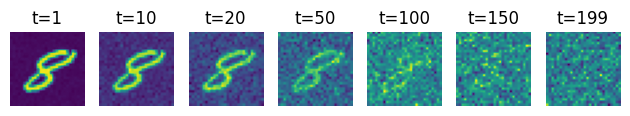

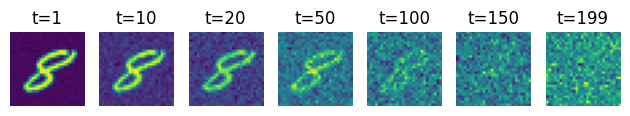

In [5]:
beta_scheduler = LinearBetaScheduler(1e-4, 0.2, 1000)
forward_process = DiffusionForwardProcess(beta_scheduler)

time_steps = [1, 10, 20, 50, 100, 150, 199]
fig, axes = plt.subplots(ncols=len(time_steps))
for ax, t in zip(axes, time_steps):
    img, _ = mnist_train_ds[2555]
    noisy_img, _ = forward_process.forward(img, torch.tensor(t))
    ax.imshow(noisy_img[0])
    ax.axis('off')
    ax.set_title(f'{t=}')

fig.tight_layout()

fig, axes = plt.subplots(ncols=len(time_steps))
for ax, t in zip(axes, time_steps):
    img, _ = mnist_train_ds[2555]
    noisy_img, _ = forward_process.forward(img[None, ...], torch.tensor([t]))
    ax.imshow(noisy_img[0, 0])
    ax.axis('off')
    ax.set_title(f'{t=}')

fig.tight_layout()

### Backward Process
#### Diffusion Backward-Process Neural Network

For the decoder network, we will just use a simple fully-connected model.
Because in this, we will focus on how the diffusion process works.

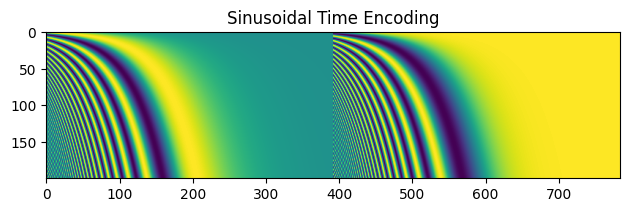

In [6]:
class SinusoidalPositionEncoding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        encodings = torch.log(torch.tensor(10000)) / (half_dim - 1)
        encodings = torch.exp(torch.arange(half_dim, device=device) * -encodings)
        encodings = time[:, None] * encodings[None, :]
        encodings = torch.cat((encodings.sin(), encodings.cos()), dim=-1)
        return encodings


time_encoder = SinusoidalPositionEncoding(28 * 28)
time_steps = torch.arange(0, 200)
encoding = time_encoder(time_steps)
plt.figure()
plt.title('Sinusoidal Time Encoding')
plt.imshow(encoding)
plt.tight_layout()

In [7]:
class MNISTDiffusionBackwardNetwork(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.flatten = nn.Flatten()
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEncoding(28 * 28),
            nn.Linear(28*28, 2048),
            nn.LayerNorm(2048),
            nn.SiLU(),
        )
        self.first = nn.Sequential(
            nn.Linear(28*28, 2048),
            nn.LayerNorm(2048),
            nn.SiLU(),
            # nn.Dropout(1),
        )

        self.hidden = nn.Sequential(
            # nn.LayerNorm(2048),
            # nn.BatchNorm1d(2048),
            # Encoder.
            nn.Linear(2048, 1024), nn.LayerNorm(1024), nn.SiLU(),
            # nn.Linear(1024, 512), nn.LayerNorm(512), nn.SiLU(),
            # nn.Linear(512, 256), nn.LayerNorm(256), nn.SiLU(),
            # nn.Linear(256, 128), nn.LayerNorm(128), nn.SiLU(),
            # # Decoder.
            # nn.Linear(128, 256), nn.LayerNorm(256), nn.SiLU(),
            # nn.Linear(256, 512), nn.LayerNorm(512), nn.SiLU(),
            # nn.Linear(512, 1024), nn.LayerNorm(1024), nn.SiLU(),
            nn.Linear(1024, 2048), nn.LayerNorm(2048), nn.SiLU(),
            nn.Linear(2048, 28 * 28),
        )
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(1, 28, 28))

    def forward(self, x, time_steps):
        x = self.flatten(x)
        x = self.first(x)
        x += self.time_mlp(time_steps)
        x = self.hidden(x)
        x = self.unflatten(x)
        return x

#### Backward Process

In backward process, the neural network is used to model the noise added.

To bad, we can really test whether our backward process is correct right now.
We will have to wait until we trained the model.
Oh well!

### Training Process
#### Loss Function

In [8]:
def diffusion_loss(pred_noise, target_noise):
    return F.mse_loss(pred_noise, target_noise)
    # return F.smooth_l1_loss(pred_noise, target_noise)

def diffusion_loss_normal(pred_noise, target_noise):
    device = pred_noise.device
    normal_dist = torch.distributions.Normal(pred_noise, torch.ones_like(pred_noise, device=device))
    return -normal_dist.log_prob(target_noise).mean()

#### Training and Evaluation Procedure

In [9]:
class MNISTDiffusionTrainingProcedure:
    def __init__(self, model: MNISTDiffusionBackwardNetwork, forward_process: DiffusionForwardProcess, device: str, lr=1e-3) -> None:
        self._model = model.to(device)
        self._forward_process = forward_process
        self._device = device

        self._optimizer = torch.optim.Adam(self._model.parameters(), lr=lr)
        model.apply(lambda m: self._init_weights(m))
        
    def _init_weights(self, m: nn.Module):
        strategy_fn = nn.init.xavier_normal_
        if type(m) in [nn.Linear]:
            strategy_fn(m.weight)

    def train(self, dataloader: DataLoader[torchvision.datasets.MNIST], epoch: int) -> float:
        self._model.train()

        nb_batches = len(dataloader)
        total_loss = 0.
        for i, (X, _) in tqdm(enumerate(dataloader), total=nb_batches, desc=f'Training epoch {epoch}'):
            loss = self._forward_step(X)#, show=(i == 0))
            total_loss += loss.item()

            # Perform gradient descent.
            self._optimizer.zero_grad()
            loss.backward()
            self._optimizer.step()

        return total_loss / nb_batches

    @torch.no_grad()
    def evaluate(self, dataloader: DataLoader[torchvision.datasets.MNIST]) -> float:
        self._model.eval()

        nb_batches = len(dataloader)
        total_loss = 0.
        for X, _ in tqdm(dataloader, total=nb_batches, desc='Evaluating'):
            total_loss += self._forward_step(X).item()

        return total_loss / nb_batches

    def _forward_step(self, X: torch.Tensor, show=False):
        # Generate noisy images.
        batch_size = X.shape[0]
        random_time_steps = torch.randint(0, self._forward_process.max_time_steps, size=(batch_size,))
        noisy_X, added_noise = self._forward_process.forward(X, random_time_steps)

        # Move the tensors to the desired device.
        noisy_X, added_noise = noisy_X.to(self._device), added_noise.to(self._device)
        random_time_steps = random_time_steps.to(self._device)

        # Feed the noisy images to model to get back predicted noise.
        pred_noise = self._model(noisy_X, random_time_steps)

        if show:
            fig, axes = plt.subplots(ncols=2)
            cs = axes[0].imshow(pred_noise[0].cpu().detach().numpy()[0])
            axes[0].set_title('Predicted Noise')
            fig.colorbar(cs, ax=axes[0])
            cs = axes[1].imshow(added_noise[0].cpu().detach().numpy()[0])
            axes[1].set_title('Original Noise')
            fig.colorbar(cs, ax=axes[1])
            fig.tight_layout()
            plt.show()

        # Calculate the loss.
        loss = diffusion_loss(pred_noise, added_noise)
        # loss = diffusion_loss_normal(pred_noise, added_noise)
        return loss

### Model Training

In [10]:
mnist_train_dataloader = DataLoader(mnist_train_ds, batch_size=256, shuffle=True)
mnist_test_dataloader = DataLoader(mnist_test_ds, batch_size=256)

In [11]:
model = MNISTDiffusionBackwardNetwork()
training_procedure = MNISTDiffusionTrainingProcedure(model, forward_process, device, lr=1e-3)

epochs = 1 if device == 'cpu' else 300
train_losses = []
test_losses = []
# torch.autograd.set_detect_anomaly(True)
for epoch in range(epochs):
    train_loss = training_procedure.train(mnist_train_dataloader, epoch)
    test_loss = training_procedure.evaluate(mnist_test_dataloader)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print(f'{train_loss=:.4f} {test_loss=:.4f}')

Training epoch 0:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.7068 test_loss=0.3457


Training epoch 1:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.2462 test_loss=0.1917


Training epoch 2:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.1643 test_loss=0.1476


Training epoch 3:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.1315 test_loss=0.1220


Training epoch 4:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.1108 test_loss=0.1068


Training epoch 5:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0981 test_loss=0.0911


Training epoch 6:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0874 test_loss=0.0885


Training epoch 7:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0795 test_loss=0.0788


Training epoch 8:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0751 test_loss=0.0750


Training epoch 9:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0711 test_loss=0.0735


Training epoch 10:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0673 test_loss=0.0652


Training epoch 11:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0641 test_loss=0.0688


Training epoch 12:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0627 test_loss=0.0633


Training epoch 13:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0617 test_loss=0.0619


Training epoch 14:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0596 test_loss=0.0601


Training epoch 15:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0575 test_loss=0.0579


Training epoch 16:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0576 test_loss=0.0566


Training epoch 17:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0553 test_loss=0.0559


Training epoch 18:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0554 test_loss=0.0545


Training epoch 19:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0544 test_loss=0.0575


Training epoch 20:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0536 test_loss=0.0573


Training epoch 21:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0544 test_loss=0.0541


Training epoch 22:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0527 test_loss=0.0545


Training epoch 23:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0526 test_loss=0.0529


Training epoch 24:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0523 test_loss=0.0535


Training epoch 25:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0515 test_loss=0.0536


Training epoch 26:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0507 test_loss=0.0526


Training epoch 27:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0521 test_loss=0.0520


Training epoch 28:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0518 test_loss=0.0505


Training epoch 29:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0505 test_loss=0.0502


Training epoch 30:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0495 test_loss=0.0511


Training epoch 31:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0507 test_loss=0.0493


Training epoch 32:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0492 test_loss=0.0499


Training epoch 33:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0493 test_loss=0.0487


Training epoch 34:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0499 test_loss=0.0541


Training epoch 35:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0485 test_loss=0.0483


Training epoch 36:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0471 test_loss=0.0495


Training epoch 37:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0487 test_loss=0.0482


Training epoch 38:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0488 test_loss=0.0512


Training epoch 39:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0486 test_loss=0.0475


Training epoch 40:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0475 test_loss=0.0451


Training epoch 41:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0473 test_loss=0.0498


Training epoch 42:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0479 test_loss=0.0468


Training epoch 43:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0473 test_loss=0.0473


Training epoch 44:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0469 test_loss=0.0485


Training epoch 45:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0462 test_loss=0.0475


Training epoch 46:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0452 test_loss=0.0455


Training epoch 47:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0466 test_loss=0.0453


Training epoch 48:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0456 test_loss=0.0459


Training epoch 49:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0458 test_loss=0.0524


Training epoch 50:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0470 test_loss=0.0470


Training epoch 51:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0458 test_loss=0.0475


Training epoch 52:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0454 test_loss=0.0438


Training epoch 53:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0448 test_loss=0.0473


Training epoch 54:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0451 test_loss=0.0486


Training epoch 55:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0460 test_loss=0.0473


Training epoch 56:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0459 test_loss=0.0458


Training epoch 57:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0455 test_loss=0.0473


Training epoch 58:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0446 test_loss=0.0474


Training epoch 59:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0443 test_loss=0.0474


Training epoch 60:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0444 test_loss=0.0455


Training epoch 61:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0451 test_loss=0.0450


Training epoch 62:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0445 test_loss=0.0457


Training epoch 63:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0440 test_loss=0.0478


Training epoch 64:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0442 test_loss=0.0462


Training epoch 65:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0439 test_loss=0.0432


Training epoch 66:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0438 test_loss=0.0458


Training epoch 67:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0437 test_loss=0.0421


Training epoch 68:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0436 test_loss=0.0463


Training epoch 69:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0433 test_loss=0.0452


Training epoch 70:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0431 test_loss=0.0428


Training epoch 71:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0430 test_loss=0.0441


Training epoch 72:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0428 test_loss=0.0459


Training epoch 73:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0429 test_loss=0.0437


Training epoch 74:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0433 test_loss=0.0465


Training epoch 75:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0439 test_loss=0.0431


Training epoch 76:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0442 test_loss=0.0430


Training epoch 77:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0424 test_loss=0.0417


Training epoch 78:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0435 test_loss=0.0455


Training epoch 79:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0424 test_loss=0.0443


Training epoch 80:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0428 test_loss=0.0421


Training epoch 81:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0424 test_loss=0.0484


Training epoch 82:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0419 test_loss=0.0438


Training epoch 83:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0433 test_loss=0.0441


Training epoch 84:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0417 test_loss=0.0453


Training epoch 85:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0413 test_loss=0.0423


Training epoch 86:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0428 test_loss=0.0466


Training epoch 87:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0420 test_loss=0.0455


Training epoch 88:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0422 test_loss=0.0424


Training epoch 89:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0418 test_loss=0.0414


Training epoch 90:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0416 test_loss=0.0428


Training epoch 91:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0411 test_loss=0.0428


Training epoch 92:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0413 test_loss=0.0401


Training epoch 93:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0421 test_loss=0.0430


Training epoch 94:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0403 test_loss=0.0422


Training epoch 95:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0415 test_loss=0.0448


Training epoch 96:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0425 test_loss=0.0425


Training epoch 97:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0406 test_loss=0.0396


Training epoch 98:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0417 test_loss=0.0407


Training epoch 99:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0415 test_loss=0.0419


Training epoch 100:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0411 test_loss=0.0405


Training epoch 101:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0407 test_loss=0.0417


Training epoch 102:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0420 test_loss=0.0423


Training epoch 103:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0414 test_loss=0.0425


Training epoch 104:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0413 test_loss=0.0414


Training epoch 105:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0406 test_loss=0.0379


Training epoch 106:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0409 test_loss=0.0429


Training epoch 107:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0412 test_loss=0.0409


Training epoch 108:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0412 test_loss=0.0438


Training epoch 109:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0413 test_loss=0.0419


Training epoch 110:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0406 test_loss=0.0429


Training epoch 111:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0407 test_loss=0.0434


Training epoch 112:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0418 test_loss=0.0430


Training epoch 113:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0404 test_loss=0.0405


Training epoch 114:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0409 test_loss=0.0436


Training epoch 115:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0391 test_loss=0.0421


Training epoch 116:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0402 test_loss=0.0401


Training epoch 117:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0408 test_loss=0.0447


Training epoch 118:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0404 test_loss=0.0393


Training epoch 119:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0399 test_loss=0.0394


Training epoch 120:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0402 test_loss=0.0427


Training epoch 121:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0395 test_loss=0.0421


Training epoch 122:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0401 test_loss=0.0424


Training epoch 123:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0395 test_loss=0.0404


Training epoch 124:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0401 test_loss=0.0421


Training epoch 125:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0404 test_loss=0.0403


Training epoch 126:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0400 test_loss=0.0423


Training epoch 127:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0392 test_loss=0.0416


Training epoch 128:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0389 test_loss=0.0401


Training epoch 129:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0404 test_loss=0.0421


Training epoch 130:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0388 test_loss=0.0417


Training epoch 131:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0403 test_loss=0.0414


Training epoch 132:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0399 test_loss=0.0411


Training epoch 133:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0395 test_loss=0.0419


Training epoch 134:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0395 test_loss=0.0401


Training epoch 135:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0397 test_loss=0.0407


Training epoch 136:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0396 test_loss=0.0382


Training epoch 137:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0389 test_loss=0.0416


Training epoch 138:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0397 test_loss=0.0408


Training epoch 139:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0388 test_loss=0.0385


Training epoch 140:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0383 test_loss=0.0416


Training epoch 141:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0390 test_loss=0.0420


Training epoch 142:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0400 test_loss=0.0390


Training epoch 143:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0393 test_loss=0.0380


Training epoch 144:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0390 test_loss=0.0419


Training epoch 145:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0382 test_loss=0.0383


Training epoch 146:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0385 test_loss=0.0408


Training epoch 147:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0389 test_loss=0.0387


Training epoch 148:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0390 test_loss=0.0408


Training epoch 149:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0385 test_loss=0.0417


Training epoch 150:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0392 test_loss=0.0406


Training epoch 151:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0392 test_loss=0.0391


Training epoch 152:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0402 test_loss=0.0388


Training epoch 153:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0375 test_loss=0.0382


Training epoch 154:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0387 test_loss=0.0384


Training epoch 155:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0390 test_loss=0.0375


Training epoch 156:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0394 test_loss=0.0406


Training epoch 157:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0383 test_loss=0.0408


Training epoch 158:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0387 test_loss=0.0386


Training epoch 159:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0390 test_loss=0.0417


Training epoch 160:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0377 test_loss=0.0395


Training epoch 161:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0380 test_loss=0.0372


Training epoch 162:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0377 test_loss=0.0384


Training epoch 163:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0384 test_loss=0.0403


Training epoch 164:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0384 test_loss=0.0393


Training epoch 165:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0378 test_loss=0.0386


Training epoch 166:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0387 test_loss=0.0397


Training epoch 167:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0388 test_loss=0.0396


Training epoch 168:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0385 test_loss=0.0384


Training epoch 169:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0372 test_loss=0.0362


Training epoch 170:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0378 test_loss=0.0365


Training epoch 171:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0375 test_loss=0.0449


Training epoch 172:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0385 test_loss=0.0391


Training epoch 173:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0371 test_loss=0.0409


Training epoch 174:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0384 test_loss=0.0397


Training epoch 175:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0374 test_loss=0.0398


Training epoch 176:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0367 test_loss=0.0366


Training epoch 177:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0382 test_loss=0.0354


Training epoch 178:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0376 test_loss=0.0386


Training epoch 179:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0379 test_loss=0.0378


Training epoch 180:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0377 test_loss=0.0397


Training epoch 181:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0378 test_loss=0.0409


Training epoch 182:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0375 test_loss=0.0374


Training epoch 183:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0372 test_loss=0.0379


Training epoch 184:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0378 test_loss=0.0380


Training epoch 185:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0373 test_loss=0.0382


Training epoch 186:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0380 test_loss=0.0383


Training epoch 187:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0379 test_loss=0.0367


Training epoch 188:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0368 test_loss=0.0386


Training epoch 189:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0376 test_loss=0.0375


Training epoch 190:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0377 test_loss=0.0375


Training epoch 191:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0370 test_loss=0.0351


Training epoch 192:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0376 test_loss=0.0421


Training epoch 193:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0372 test_loss=0.0393


Training epoch 194:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0363 test_loss=0.0374


Training epoch 195:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0363 test_loss=0.0395


Training epoch 196:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0371 test_loss=0.0356


Training epoch 197:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0370 test_loss=0.0412


Training epoch 198:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0371 test_loss=0.0357


Training epoch 199:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0355 test_loss=0.0396


Training epoch 200:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0361 test_loss=0.0388


Training epoch 201:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0367 test_loss=0.0352


Training epoch 202:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0372 test_loss=0.0378


Training epoch 203:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0369 test_loss=0.0374


Training epoch 204:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0366 test_loss=0.0373


Training epoch 205:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0363 test_loss=0.0396


Training epoch 206:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0369 test_loss=0.0400


Training epoch 207:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0358 test_loss=0.0355


Training epoch 208:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0363 test_loss=0.0349


Training epoch 209:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0365 test_loss=0.0394


Training epoch 210:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0367 test_loss=0.0358


Training epoch 211:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0380 test_loss=0.0379


Training epoch 212:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0364 test_loss=0.0363


Training epoch 213:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0363 test_loss=0.0351


Training epoch 214:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0362 test_loss=0.0363


Training epoch 215:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0348 test_loss=0.0371


Training epoch 216:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0361 test_loss=0.0386


Training epoch 217:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0363 test_loss=0.0364


Training epoch 218:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0360 test_loss=0.0358


Training epoch 219:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0365 test_loss=0.0356


Training epoch 220:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0358 test_loss=0.0362


Training epoch 221:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0361 test_loss=0.0366


Training epoch 222:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0356 test_loss=0.0376


Training epoch 223:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0364 test_loss=0.0352


Training epoch 224:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0371 test_loss=0.0377


Training epoch 225:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0358 test_loss=0.0367


Training epoch 226:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0356 test_loss=0.0365


Training epoch 227:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0352 test_loss=0.0360


Training epoch 228:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0360 test_loss=0.0354


Training epoch 229:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0348 test_loss=0.0372


Training epoch 230:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0358 test_loss=0.0383


Training epoch 231:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0353 test_loss=0.0371


Training epoch 232:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0361 test_loss=0.0361


Training epoch 233:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0345 test_loss=0.0356


Training epoch 234:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0352 test_loss=0.0362


Training epoch 235:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0358 test_loss=0.0352


Training epoch 236:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0354 test_loss=0.0357


Training epoch 237:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0345 test_loss=0.0345


Training epoch 238:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0359 test_loss=0.0337


Training epoch 239:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0353 test_loss=0.0376


Training epoch 240:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0350 test_loss=0.0352


Training epoch 241:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0353 test_loss=0.0368


Training epoch 242:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0340 test_loss=0.0344


Training epoch 243:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0354 test_loss=0.0365


Training epoch 244:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0354 test_loss=0.0374


Training epoch 245:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0348 test_loss=0.0362


Training epoch 246:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0354 test_loss=0.0362


Training epoch 247:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0350 test_loss=0.0381


Training epoch 248:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0357 test_loss=0.0339


Training epoch 249:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0349 test_loss=0.0380


Training epoch 250:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0346 test_loss=0.0342


Training epoch 251:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0350 test_loss=0.0361


Training epoch 252:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0346 test_loss=0.0341


Training epoch 253:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0338 test_loss=0.0354


Training epoch 254:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0343 test_loss=0.0352


Training epoch 255:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0353 test_loss=0.0354


Training epoch 256:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0353 test_loss=0.0374


Training epoch 257:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0351 test_loss=0.0355


Training epoch 258:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0350 test_loss=0.0349


Training epoch 259:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0345 test_loss=0.0368


Training epoch 260:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0348 test_loss=0.0363


Training epoch 261:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0342 test_loss=0.0347


Training epoch 262:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0345 test_loss=0.0364


Training epoch 263:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0343 test_loss=0.0341


Training epoch 264:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0341 test_loss=0.0339


Training epoch 265:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0344 test_loss=0.0342


Training epoch 266:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0344 test_loss=0.0346


Training epoch 267:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0342 test_loss=0.0360


Training epoch 268:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0339 test_loss=0.0344


Training epoch 269:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0340 test_loss=0.0338


Training epoch 270:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0338 test_loss=0.0350


Training epoch 271:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0338 test_loss=0.0348


Training epoch 272:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0345 test_loss=0.0346


Training epoch 273:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0342 test_loss=0.0387


Training epoch 274:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0342 test_loss=0.0338


Training epoch 275:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0345 test_loss=0.0329


Training epoch 276:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0333 test_loss=0.0334


Training epoch 277:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0335 test_loss=0.0370


Training epoch 278:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0335 test_loss=0.0347


Training epoch 279:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0336 test_loss=0.0347


Training epoch 280:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0338 test_loss=0.0363


Training epoch 281:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0334 test_loss=0.0337


Training epoch 282:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0341 test_loss=0.0341


Training epoch 283:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0344 test_loss=0.0355


Training epoch 284:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0337 test_loss=0.0333


Training epoch 285:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0336 test_loss=0.0318


Training epoch 286:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0338 test_loss=0.0313


Training epoch 287:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0340 test_loss=0.0345


Training epoch 288:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0343 test_loss=0.0363


Training epoch 289:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0337 test_loss=0.0331


Training epoch 290:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0343 test_loss=0.0363


Training epoch 291:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0334 test_loss=0.0338


Training epoch 292:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0332 test_loss=0.0331


Training epoch 293:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0331 test_loss=0.0329


Training epoch 294:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0332 test_loss=0.0346


Training epoch 295:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0337 test_loss=0.0330


Training epoch 296:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0328 test_loss=0.0337


Training epoch 297:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0332 test_loss=0.0341


Training epoch 298:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0341 test_loss=0.0335


Training epoch 299:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

train_loss=0.0328 test_loss=0.0353


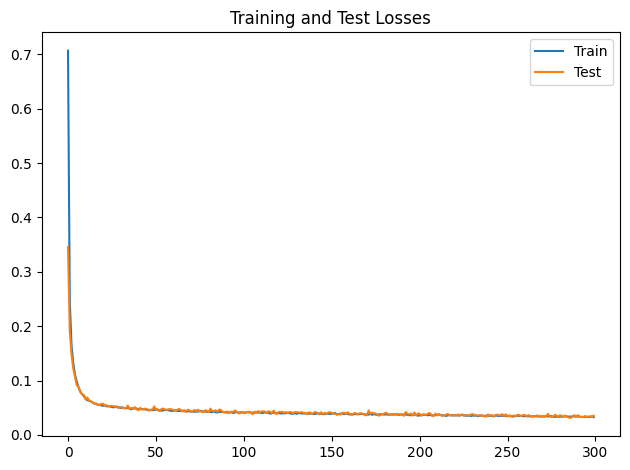

In [12]:
plt.figure()
plt.title('Training and Test Losses')
plt.plot(range(epochs), train_losses, label='Train')
plt.plot(range(epochs), test_losses, label='Test')
plt.legend()
plt.tight_layout()

### Results

In [13]:
class DiffusionBackwardProcess:
    def __init__(self, model: MNISTDiffusionBackwardNetwork, beta_scheduler: BetaScheduler, device: str) -> None:
        self._model = model
        self._beta_scheduler = beta_scheduler
        self._device = device

    @torch.no_grad()
    def backward(self, noisy_img: torch.Tensor, time_step: int) -> torch.Tensor:
        """
        Perform diffusion backward process (the sampling algorithm in the paper).

        Parameters
        ==========
        noisy_img: torch.Tensor
            Noisy images, a tensor of shape (N, C, H, W) for batched input or (C, H, W) for unbatched input.
        time_step: int
            Time step of all images.
        """
        self._model.eval()
        is_batched_input = len(noisy_img.shape) == 4
        if is_batched_input:
            batch_size = noisy_img.shape[0]
            time_steps = torch.tensor([time_step]*batch_size)
        else:
            noisy_img = noisy_img[None, ...]
            time_steps = torch.tensor([time_step])

        pred_noise = self._model(noisy_img.to(self._device), time_steps.to(self._device)).cpu()
        means = self._means(noisy_img, pred_noise, time_steps)

        if time_step == 0:
            means = self._discretize(means)
            return means if is_batched_input else means[0]
        else:
            posterior_variances = self._posterior_variances(time_steps)
            random_noise = torch.randn_like(noisy_img)

            x = means + random_noise * torch.sqrt(posterior_variances)
            return x if is_batched_input else x[0]

    def _means(self, noisy_img: torch.Tensor, pred_noise: torch.Tensor, time_steps: torch.Tensor):
        """
        Calculate mean.
        """
        # TODO: how to handle time_steps = 0?
        sqrt_alpha_recip = 1. / torch.sqrt(self._beta_scheduler.alpha(time_steps))
        sqrt_1_minus_alpha_bar = self._beta_scheduler.sqrt_1_minus_alpha_bar(time_steps)
        beta = self._beta_scheduler.beta(time_steps)

        return sqrt_alpha_recip * (noisy_img - beta * pred_noise / sqrt_1_minus_alpha_bar)

    def _posterior_variances(self, time_steps: torch.Tensor) -> torch.Tensor:
        """
        Calculate posterior variances.

        Parameters
        ==========
        time_steps: torch.Tensor
            Time steps, can be a scalar tensor or a tensor of shape (N,).
        """
        # TODO: how to handle time_steps = 0?
        beta = self._beta_scheduler.beta(time_steps)
        one_minus_alpha_bar_t = self._beta_scheduler.one_minus_alpha_bar(time_steps)
        one_minus_alpha_bat_t_1 = self._beta_scheduler.one_minus_alpha_bar(time_steps - 1)
        return beta * one_minus_alpha_bat_t_1 / one_minus_alpha_bar_t
    
    def _discretize(self, images: torch.Tensor) -> torch.Tensor:
        images = torch.clip(images, -1, 1)
        # images = 255 * (images + 1) / 2
        return images

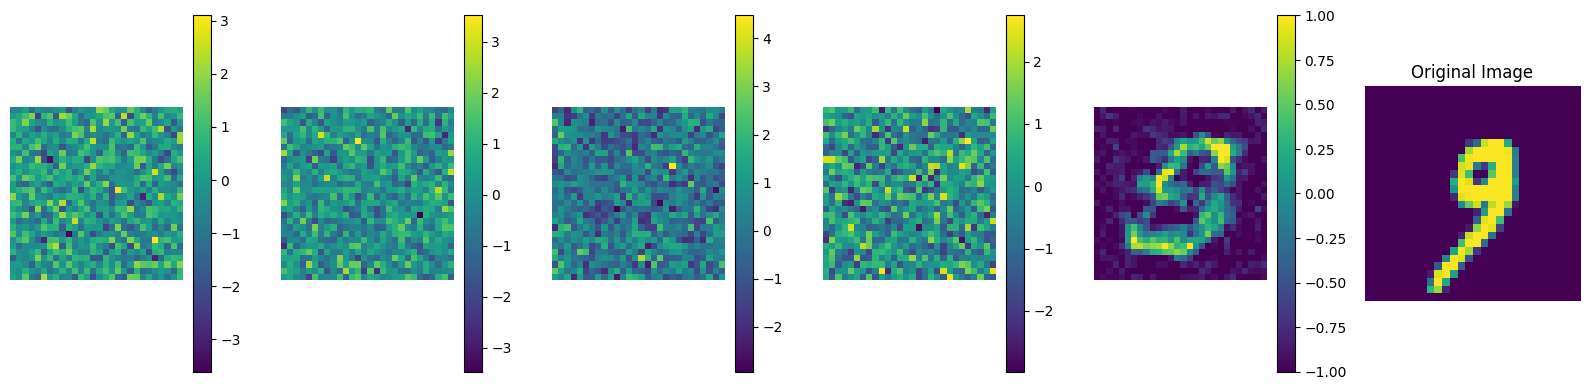

In [14]:
backward_process = DiffusionBackwardProcess(model, beta_scheduler, device)

original_img, _ = mnist_test_ds[1000]
noisy_img, _ = forward_process.forward(
    original_img, torch.tensor(forward_process.max_time_steps - 1))
recovered_imgs = []
recovered_img = noisy_img
for i in reversed(range(forward_process.max_time_steps)):
    recovered_img = backward_process.backward(recovered_img, i)

    if i % 200 == 0:
        recovered_imgs.append(recovered_img)

fig, axes = plt.subplots(ncols=len(recovered_imgs) + 1, figsize=(16, 4))
for ax, img in zip(axes, recovered_imgs):
    cs = ax.imshow(img[0])
    fig.colorbar(cs, ax=ax)
    ax.axis('off')

axes[-1].imshow(original_img[0])
axes[-1].set_title('Original Image')
axes[-1].axis('off')
fig.tight_layout()